In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from statsmodels.tsa.arima.model import ARIMA as ARIMA

## Data Preparation

In [2]:
# Import Data, Train & Holiday_Events
store = pd.read_csv("store-sales-time-series-forecasting/train.csv")
holiday_events = pd.read_excel("store-sales-time-series-forecasting/holidays_events.xlsx")

print(store.head())
print("\n")
print(holiday_events.head())

   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0


        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  


In [3]:
# Clean Data, Keep 'date' & 'type'
holiday_events = holiday_events[['date', 'type']]

# Change all 'type' Object to Float 1
holiday_events['type'] = 1

# Change 'type' to 'holiday'
holiday_events = holiday_events.rename(columns={'type': 'holiday'})

# Change Object to DateTime64
store['date'] = pd.to_datetime(store['date'])

# Compile Data
csv = pd.merge(store, holiday_events, on='date', how='outer')
csv = csv.fillna(0)

# Clean Data, Keep any food related 'family'
csv = csv[(csv['family'] == 'BREAD/BAKERY') |
          (csv['family'] == 'DAIRY') |
          (csv['family'] == 'DELI') |
          (csv['family'] == 'EGGS') |
          (csv['family'] == 'FROZEN FOODS') |
          (csv['family'] == 'MEATS') | 
          (csv['family'] == 'POULTRY') |
          (csv['family'] == 'PREPARED FOODS') | 
          (csv['family'] == 'PRODUCE') |
          (csv['family'] == 'SEAFOOD')]

# Clean Data, Keep 'store_nbr' related to Quito
csv = csv[(csv['store_nbr'] == 1.0) |
          (csv['store_nbr'] == 2.0) |
          (csv['store_nbr'] == 3.0) |
          (csv['store_nbr'] == 4.0) |
          (csv['store_nbr'] == 6.0) |
          (csv['store_nbr'] == 7.0) | 
          (csv['store_nbr'] == 8.0) |
          (csv['store_nbr'] == 9.0) | 
          (csv['store_nbr'] == 10.0) |
          (csv['store_nbr'] == 17.0) |
          (csv['store_nbr'] == 18.0) |
          (csv['store_nbr'] == 20.0) |
          (csv['store_nbr'] == 44.0) |
          (csv['store_nbr'] == 45.0) |
          (csv['store_nbr'] == 46.0) |
          (csv['store_nbr'] == 47.0) |
          (csv['store_nbr'] == 48.0) |
          (csv['store_nbr'] == 49.0)]

csv = csv.drop_duplicates()
print(csv.head())

      id       date  store_nbr        family  sales  onpromotion  holiday
5    5.0 2013-01-01        1.0  BREAD/BAKERY    0.0          0.0      1.0
8    8.0 2013-01-01        1.0         DAIRY    0.0          0.0      1.0
9    9.0 2013-01-01        1.0          DELI    0.0          0.0      1.0
10  10.0 2013-01-01        1.0          EGGS    0.0          0.0      1.0
11  11.0 2013-01-01        1.0  FROZEN FOODS    0.0          0.0      1.0


## Exploratory Data Analysis

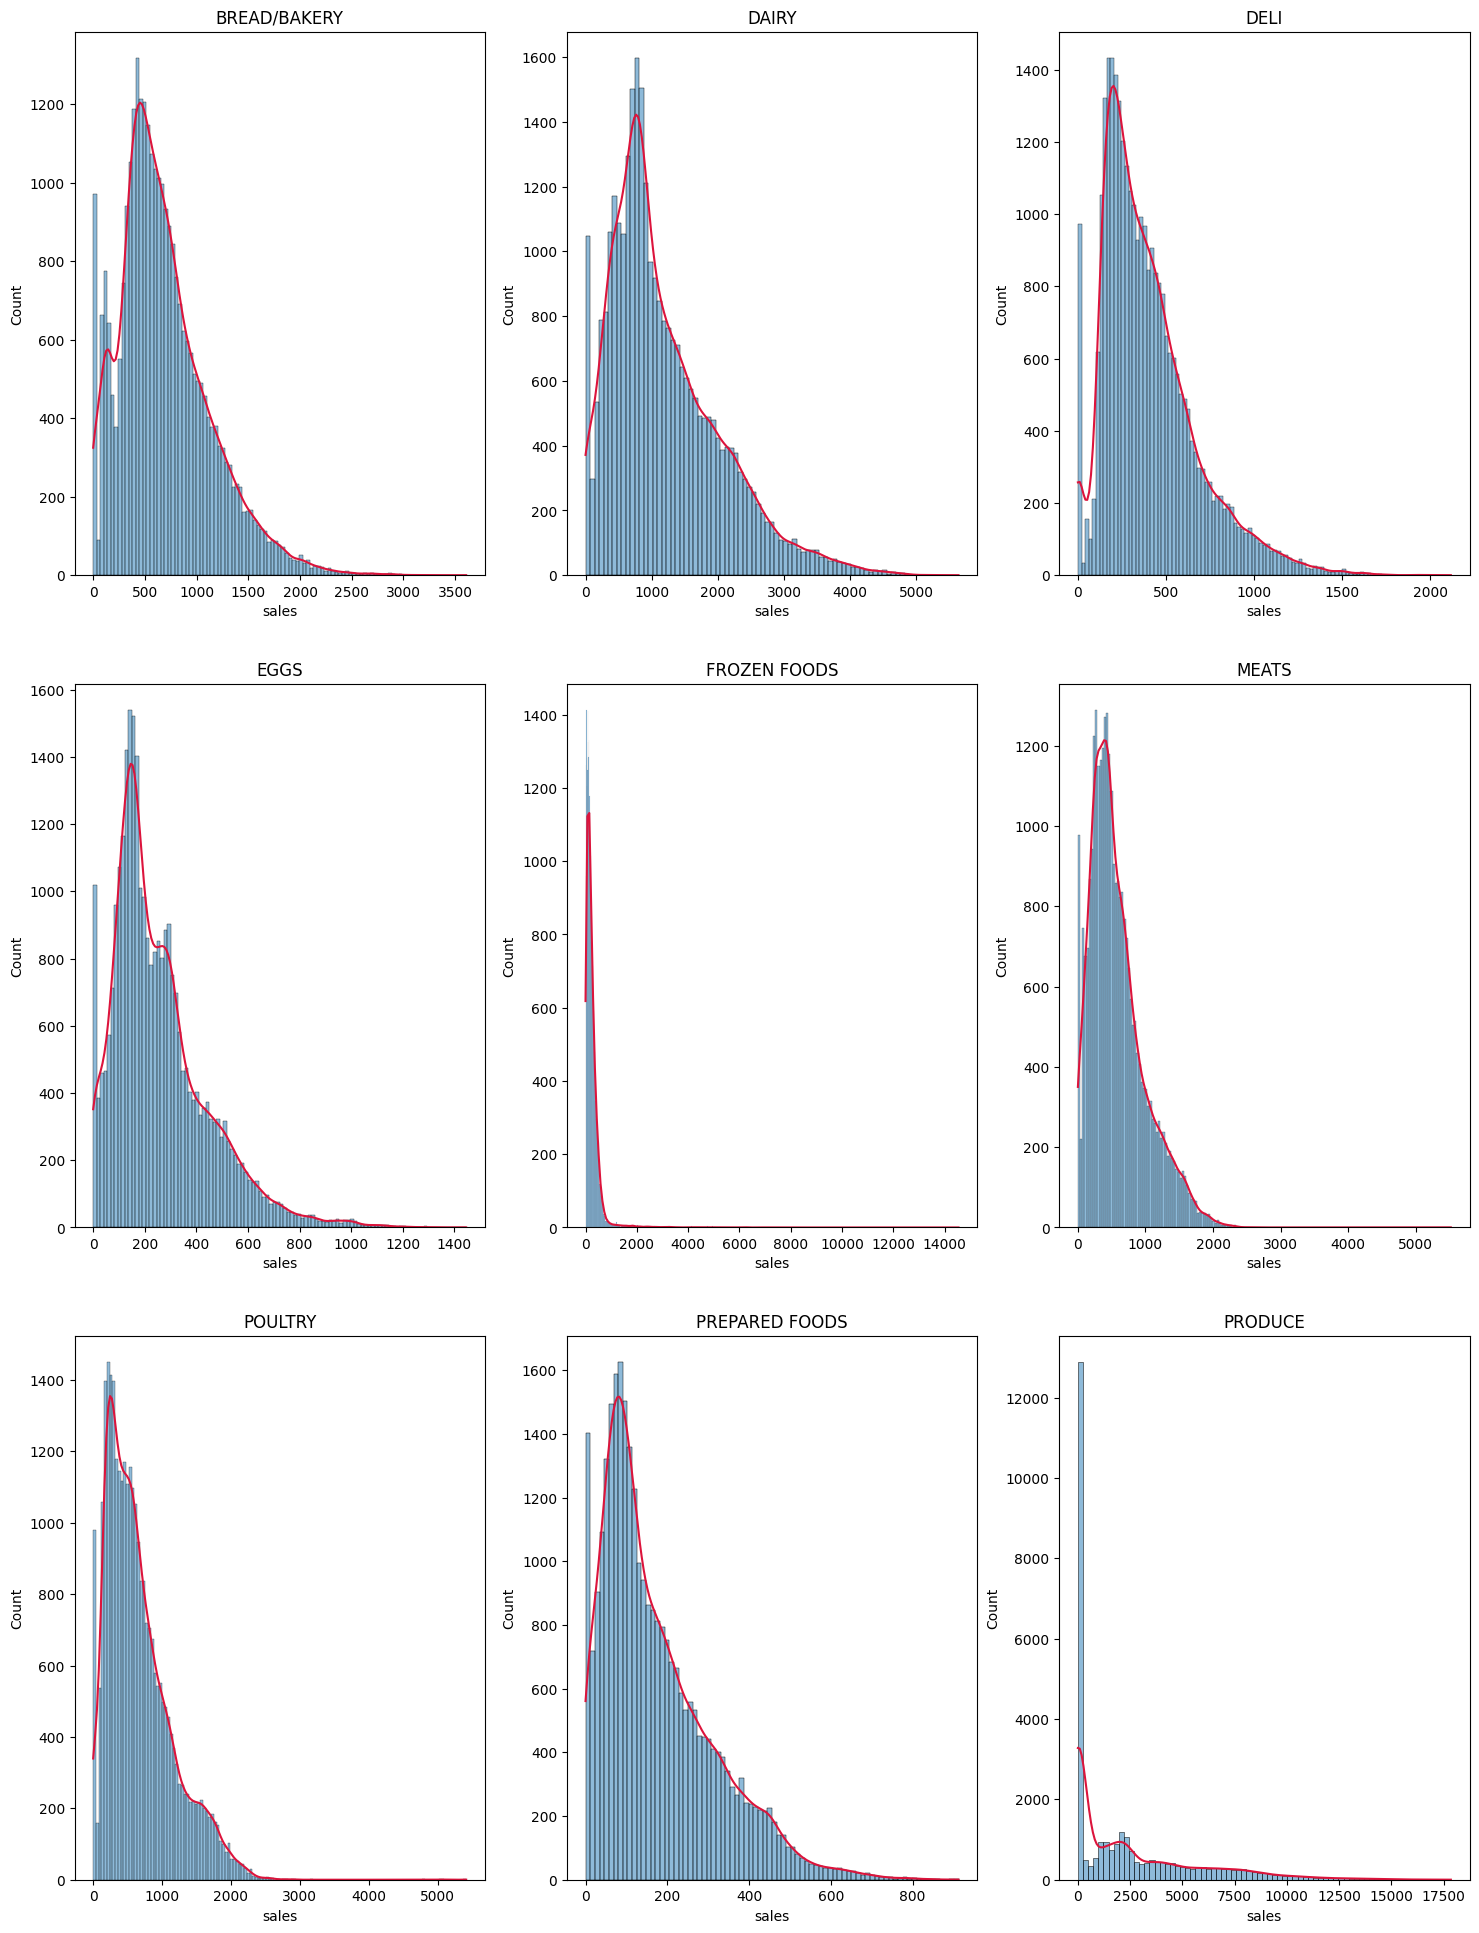

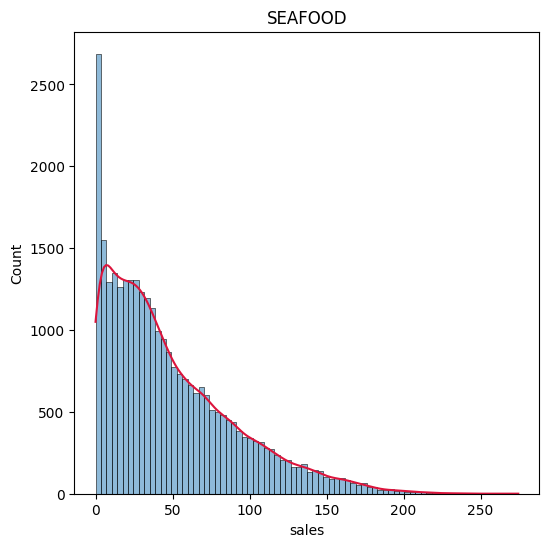

In [4]:
# Distribution: Average Sale

# create a 3x3 grid of subplots
f, axes = plt.subplots(3, 3, figsize=(18, 24))

# list of 'family' names for the header
family_names = ['BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 
                'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE']

# plot histograms for each 'family' in the grid
for i, family in enumerate(family_names):
    row = i // 3
    col = i % 3
    ax = sb.histplot(data=csv[csv['family'] == family], x='sales', ax=axes[row, col], kde=True)
    ax.lines[0].set_color('crimson')
    axes[row, col].set_title(family)
    
f, axes = plt.subplots(1, 1, figsize=(6, 6))
    
# plot histogram for 'SEAFOOD' outside the grid
seafood_plot = sb.histplot(data=csv[csv['family'] == 'SEAFOOD'], x='sales', kde=True)
seafood_plot.lines[0].set_color('crimson')
seafood_plot.set_title('SEAFOOD')

# display the plots
plt.show()

Based on the distribution curves, we can observe that the majority of the curves appear narrow, indicating that the data points are closely clustered together for each year between 2014 and 2017. This suggests that the sales within each category are relatively consistent over time, with little variation from year to year.

Next, we try to plot out the sales of each category over the years.

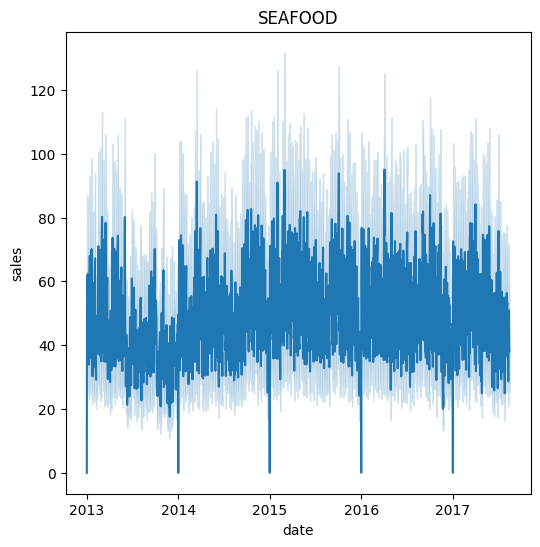

In [5]:
# LinePlot (Daily) of 'SEAFOOD'

f, axes = plt.subplots(1, 1, figsize=(6, 6))
seafood_plot = sb.lineplot(data=csv[csv['family'] == 'SEAFOOD'], x='date', y='sales')
seafood_plot.set_title('SEAFOOD')
plt.show()

Due to the high number of dates, it was difficult to analyze the data from the plot. To address this, we resampled the data into weekly intervals instead of daily intervals.

In [6]:
# convert the index to a datetime index
csv.set_index('date', inplace=True)

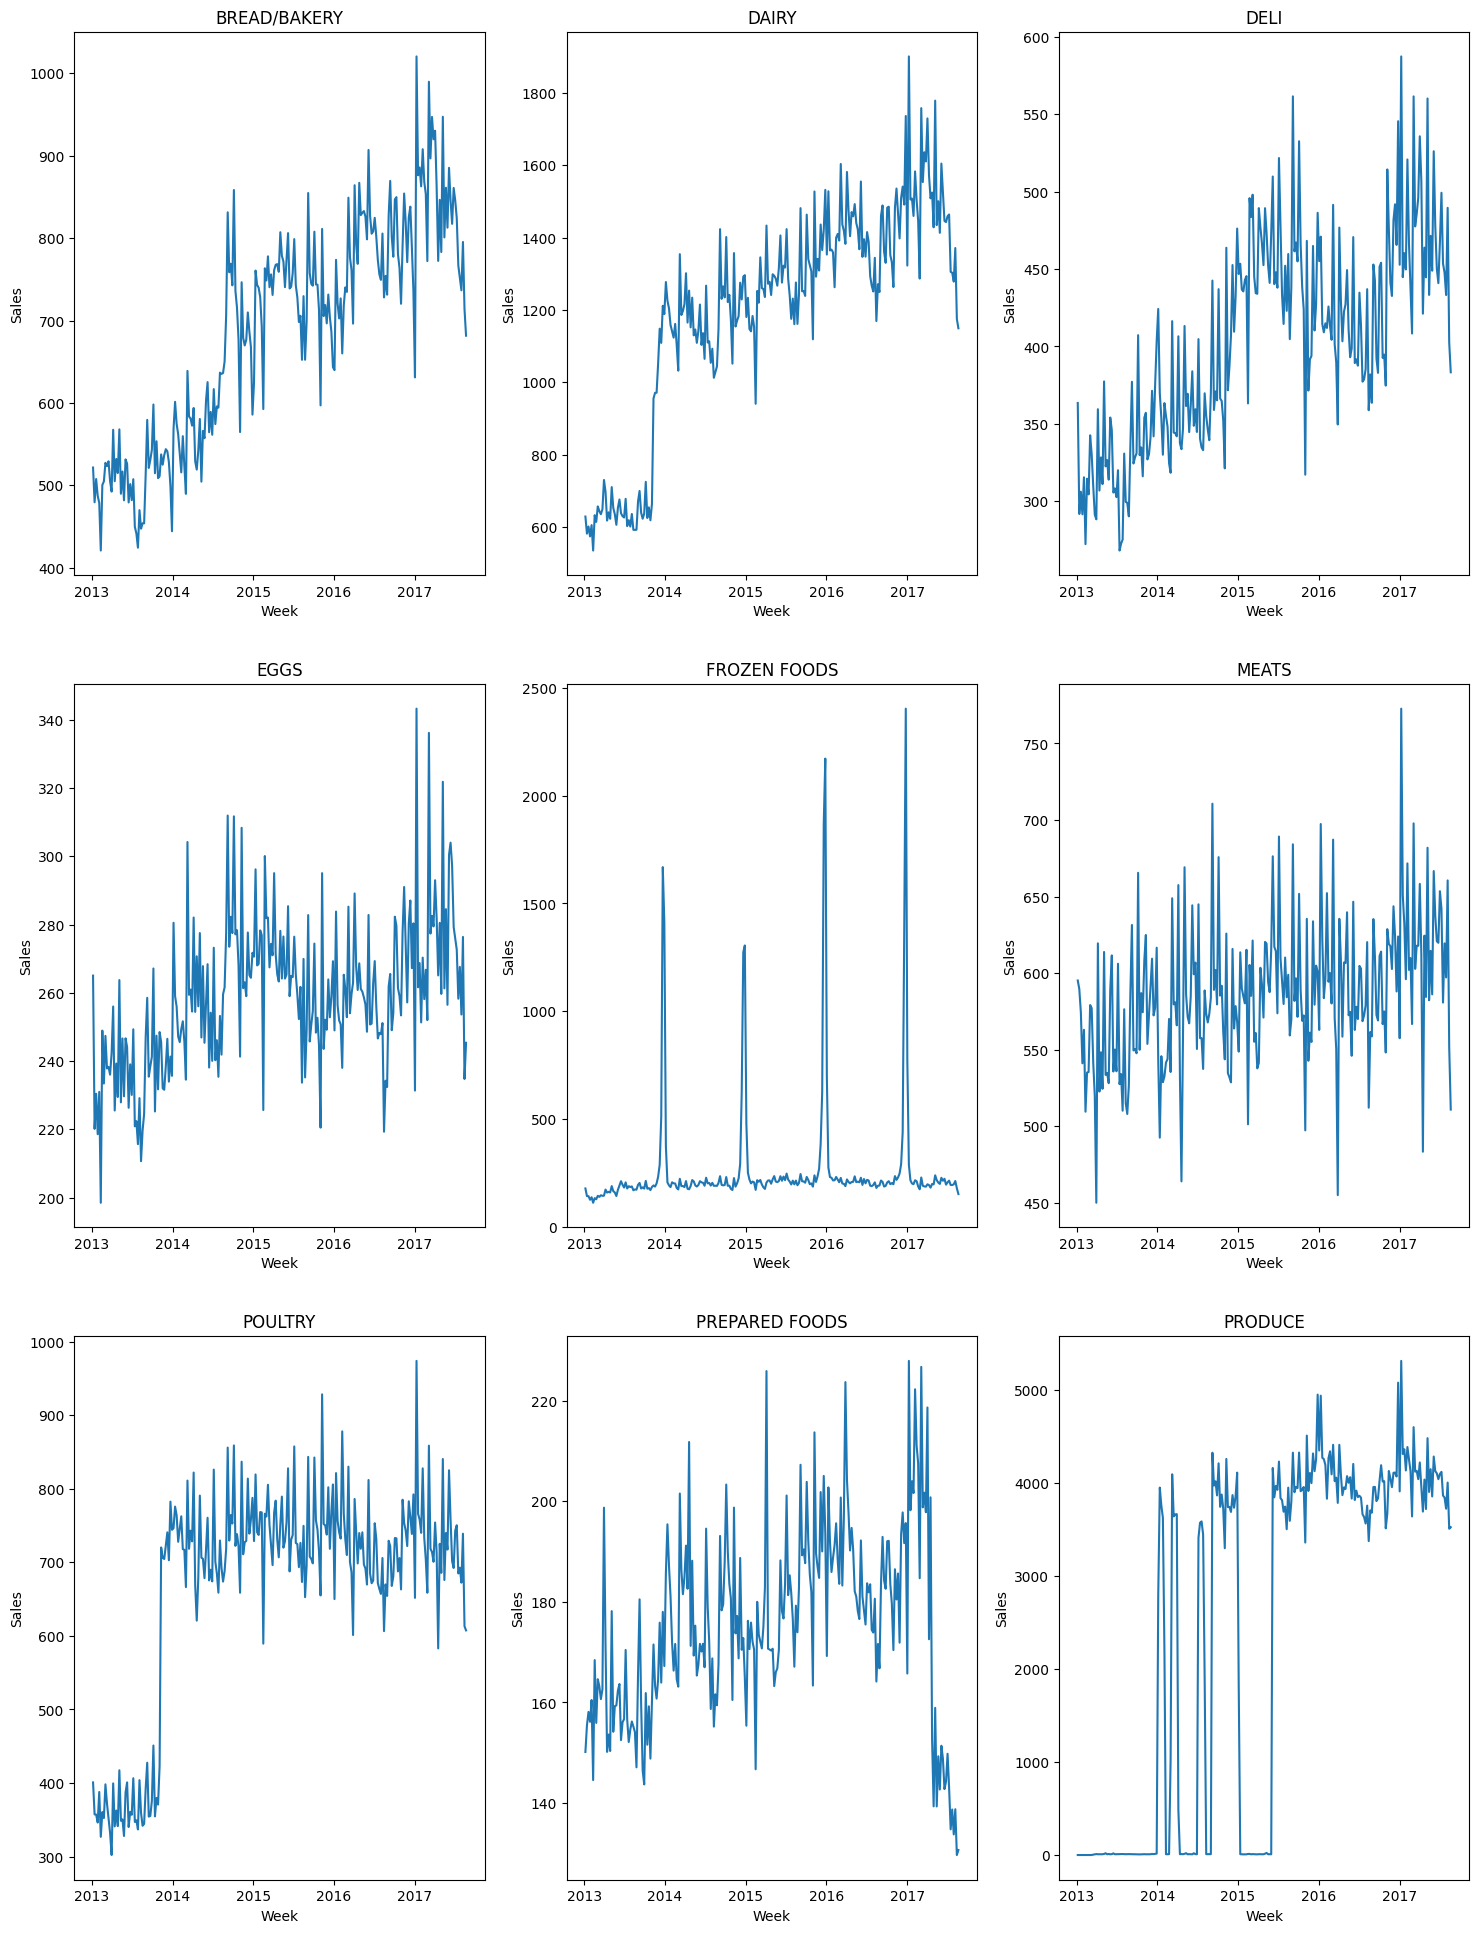

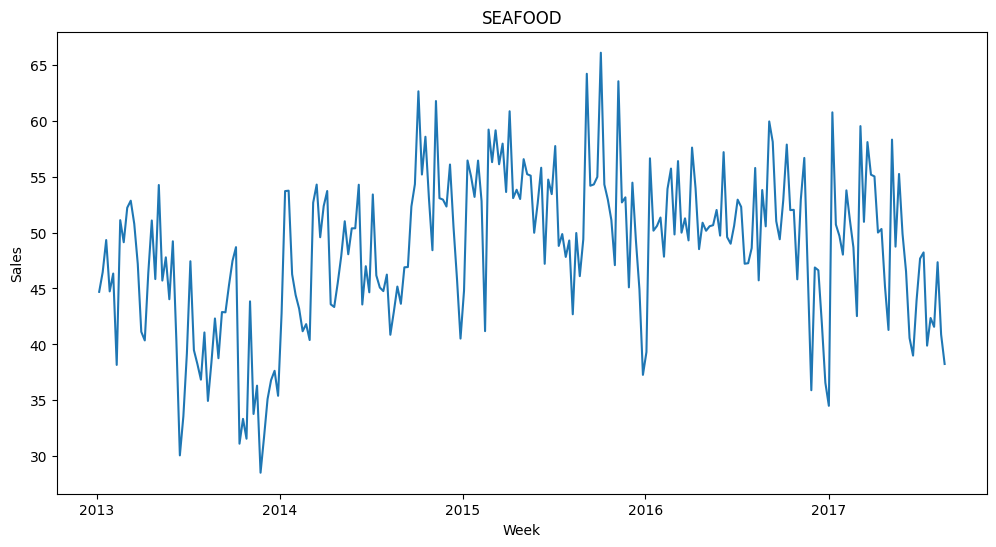

In [7]:
# LinePlot (Weekly)

# create a 3x3 grid of subplots
f, axes = plt.subplots(3, 3, figsize=(18, 24))

# list of family names for the plots
family_names = ['BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 
                'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE']

# iterate through the families and plot the weekly sales for each
for i, family in enumerate(family_names):
    row = i // 3
    col = i % 3
    # filter for the family
    family_data = csv[csv['family'] == family]
    # group by week and calculate mean sales
    weekly_sales = family_data.resample('W').agg({'sales':'mean'})
    # plot the line chart
    sb.lineplot(data=weekly_sales, x=weekly_sales.index, y='sales', ax=axes[row, col])
    # set the title for the subplot
    axes[row, col].set_title(family)
    # set the x-label for the subplot
    axes[row, col].set_xlabel('Week')
    # set the y-label for the subplot
    axes[row, col].set_ylabel('Sales')

# filter for the 'SEAFOOD' family
family_data = csv[csv['family'] == 'SEAFOOD']

# group the data by week and calculate the mean sales for each week
weekly_sales = family_data.resample('W').agg({'sales':'mean'})

# create a line plot of weekly sales for the 'SEAFOOD' family
f, ax = plt.subplots(1, 1, figsize=(12, 6))
sb.lineplot(data=weekly_sales, x=weekly_sales.index, y='sales', ax=ax)
ax.set_title('SEAFOOD')
ax.set_xlabel('Week')
ax.set_ylabel('Sales')
plt.show()

From the time series plots, we can observe a general increase in food sales over the years. This observation supports our earlier findings from the distribution plots.

## Correlation
From the available data, there are other variables that we would like to investigate in order to determine if they have any correlation with food sales. If there is a correlation, we will attempt to incorporate those variables into our prediction model.

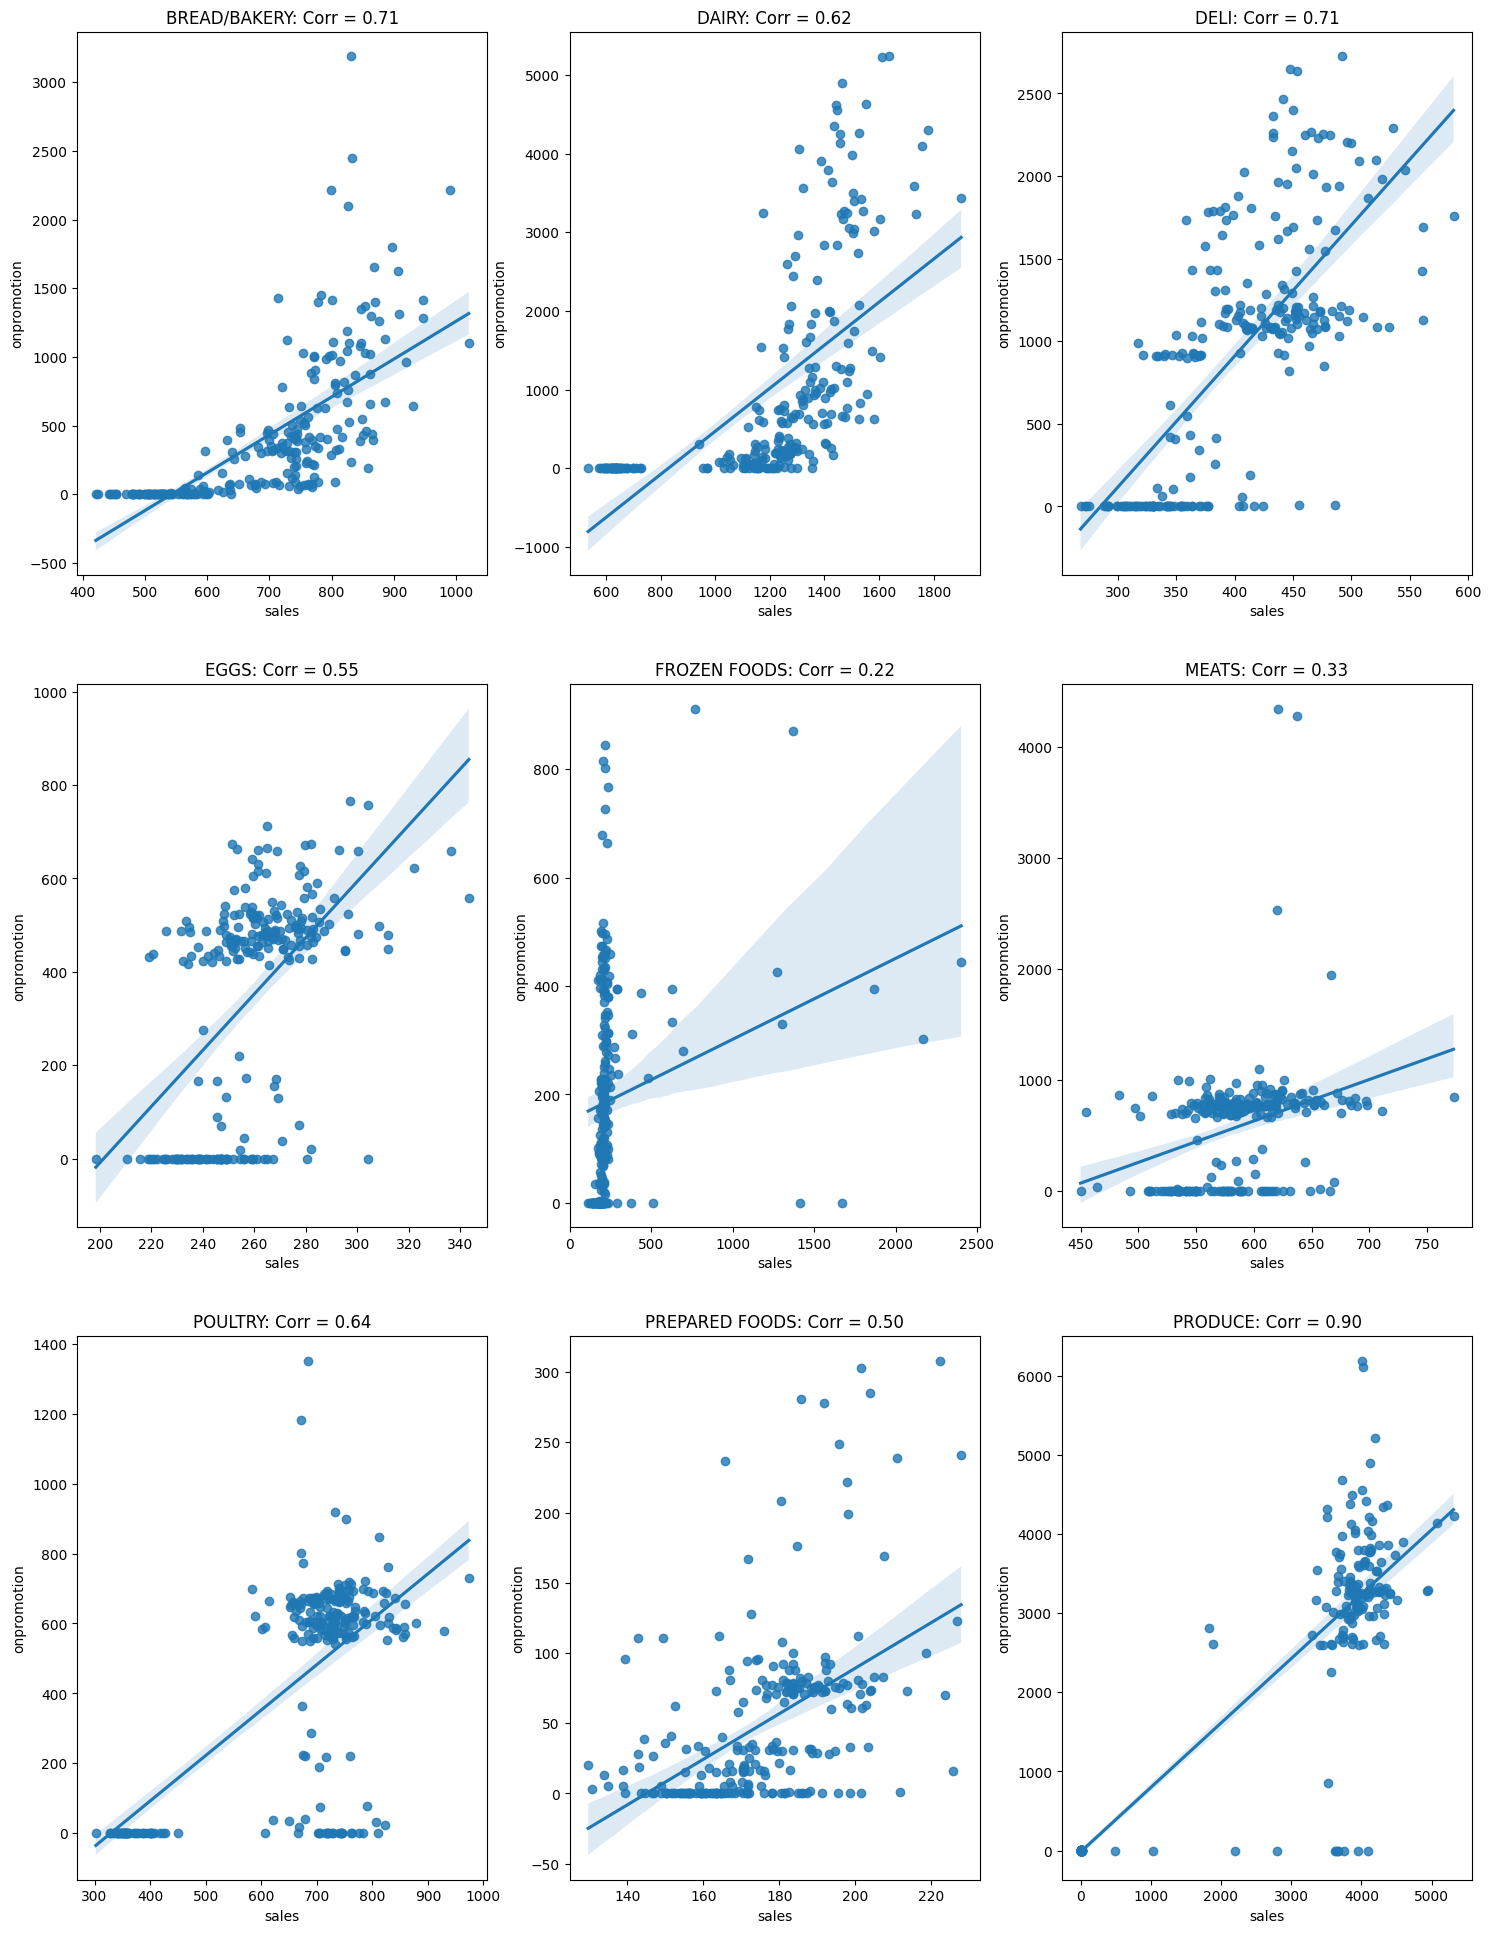

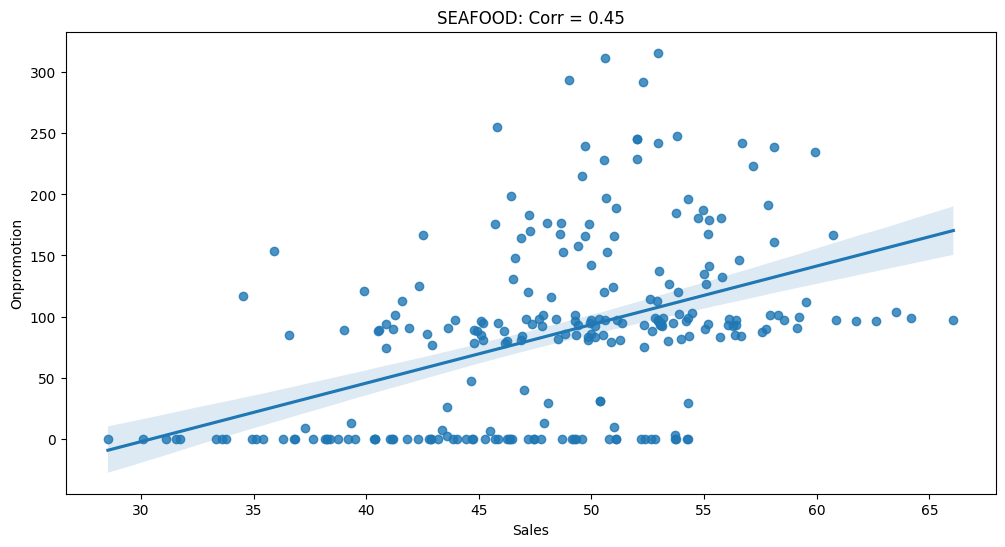

In [8]:
# Correlation of Onpromotion vs Sales (Weekly)

# List of family names for the plots
family_names = ['BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 
                'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE']

# Create a 3x3 grid of subplots
f, axes = plt.subplots(3, 3, figsize=(18, 24))

# Iterate through the families and plot the weekly sales for each
for i, family in enumerate(family_names):
    row = i // 3
    col = i % 3
    # Filter for the family
    family_data = csv[csv['family'] == family]
    # Group by week and calculate mean sales and onpromotion counts
    weekly_sales = family_data.resample('W').agg({'sales':'mean', 'onpromotion':'sum'})
    # Calculate the correlation coefficient
    corr_coef = weekly_sales['sales'].corr(weekly_sales['onpromotion'])
    # Create the scatter plot with best fit line and correlation coefficient
    sb.regplot(data=weekly_sales, x='sales', y='onpromotion', ax=axes[row, col])
    axes[row, col].set_title(f'{family}: Corr = {corr_coef:.2f}')
    
# Filter for the 'SEAFOOD' family
family_data = csv[csv['family'] == 'SEAFOOD']
# Group by week and calculate mean sales and onpromotion counts
weekly_sales = family_data.resample('W').agg({'sales':'mean', 'onpromotion':'sum'})
# Calculate the correlation coefficient
corr_coef = weekly_sales['sales'].corr(weekly_sales['onpromotion'])
# Create the scatter plot with best fit line and correlation coefficient in title
f, ax = plt.subplots(1, 1, figsize=(12, 6))
sb.regplot(data=weekly_sales, x='sales', y='onpromotion', ax=ax)
ax.set_title(f'SEAFOOD: Corr = {corr_coef:.2f}')
ax.set_xlabel('Sales')
ax.set_ylabel('Onpromotion')

# Show the plot
plt.show()

The plots and correlation calculations suggest that there is a moderate to high correlation for each category. Therefore, it appears that the variable "onpromotion" has an effect on food sales, and we should include it in our predictive model.

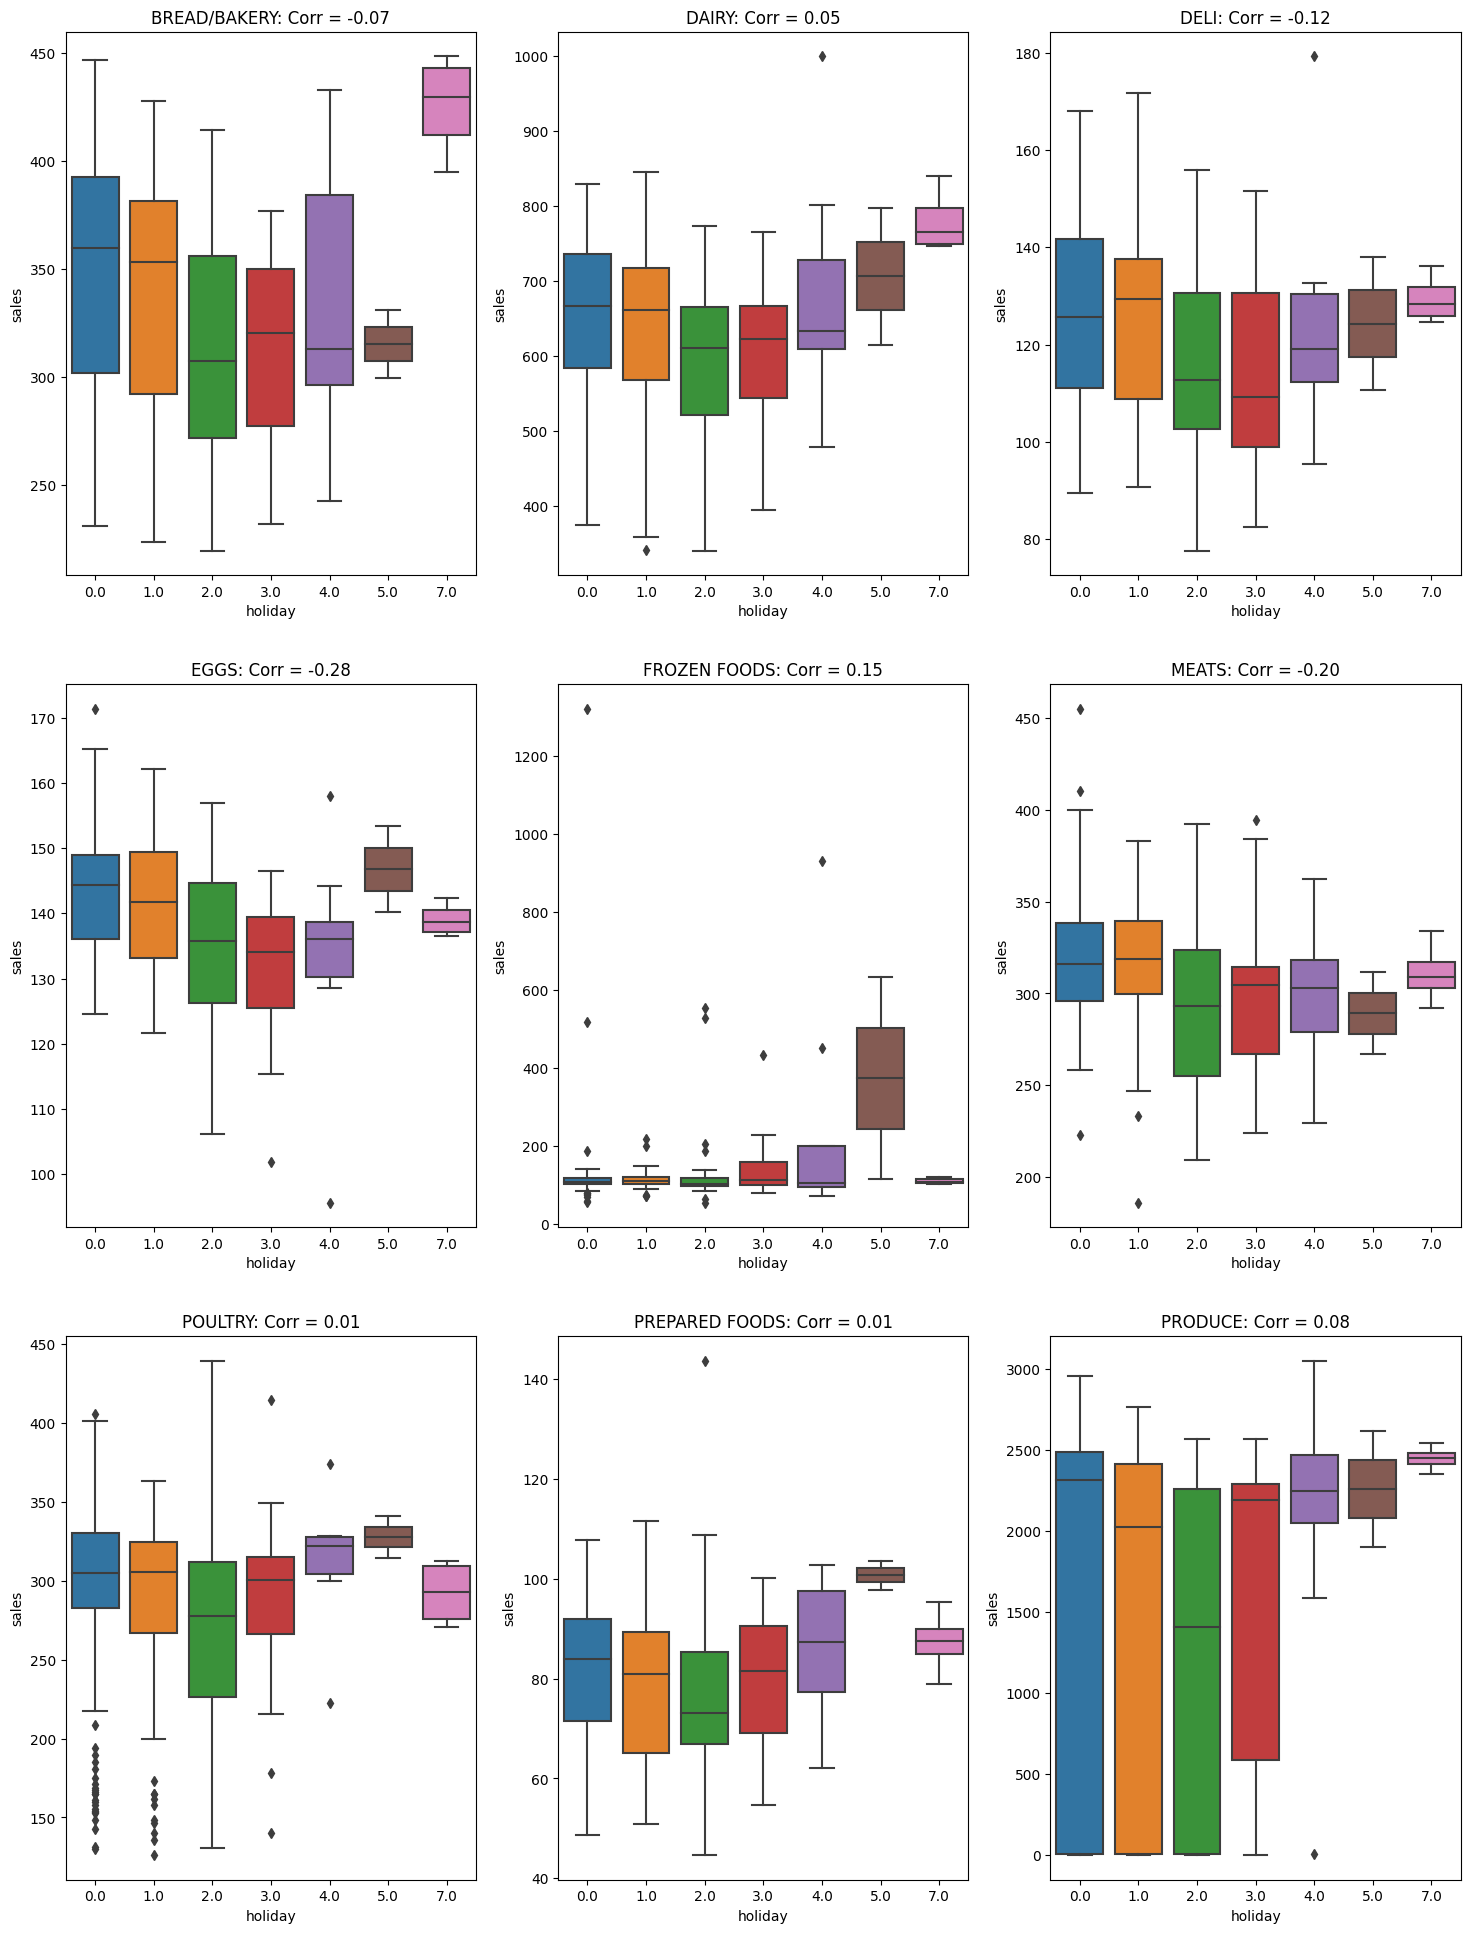

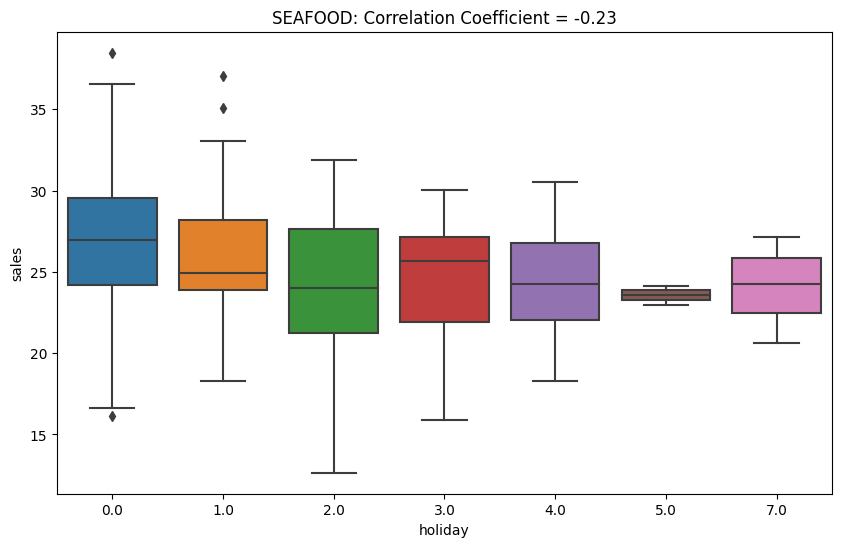

In [9]:
# Boxplot of holiday vs Sales (Weekly) for Store 1

# List of family names for the plots
family_names = ['BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 
                'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE']

# Create a 3x3 grid of subplots
f, axes = plt.subplots(3, 3, figsize=(18, 24))

# Iterate through the families and plot the weekly sales for each
for i, family in enumerate(family_names):
    row = i // 3
    col = i % 3
    # Filter for the family
    family_data = csv[csv['family'] == family]
    family_data = family_data.loc[family_data['store_nbr'] == 1.0]
    # Group by week and calculate mean sales and onpromotion counts
    weekly_sales = family_data.resample('W').agg({'sales':'mean', 'holiday':'sum'})
    # Calculate the correlation coefficient
    corr_coef = weekly_sales['sales'].corr(weekly_sales['holiday'])
    # Create the boxplot
    sb.boxplot(data=weekly_sales, x='holiday', y='sales', ax=axes[row, col])
    axes[row, col].set_title(f'{family}: Corr = {corr_coef:.2f}')
    
# Filter for the 'SEAFOOD' family
family_data = csv[csv['family'] == 'SEAFOOD']
family_data = family_data.loc[family_data['store_nbr'] == 1.0]
# Group by week and calculate mean sales and onpromotion counts
weekly_sales = family_data.resample('W').agg({'sales':'mean', 'holiday':'sum'})
# Calculate the correlation coefficient
corr_coef = weekly_sales['sales'].corr(weekly_sales['holiday'])
# Create a box plot to visualize sales distribution
f, ax = plt.subplots(figsize=(10, 6))
sb.boxplot(data=weekly_sales, x='holiday', y='sales', ax=ax)
ax.set_title(f'SEAFOOD: Correlation Coefficient = {corr_coef:.2f}')

# Show the plot
plt.show()

The BoxPlot above suggests that higher holiday occurrences are associated with higher sales, despite the low correlation. Therefore, it is worthwhile to investigate whether this variable should be included in the model.

## Summary of EDA
- In general, it appears that food sales have increased over the years, so we should expect current prices to be slightly higher than before.
- Two variables that we should pay attention to are 'onpromotion', which represents the number of items on promotion for a given week, and 'holiday', which represents the number of holidays occurring in that week. These variables appear to be factors that influence food sales.

# Model

Our strategy for addressing this problem is to train the model to focus exclusively on a single food category. This approach should help the model generalize better than if we were to use data that includes multiple food categories. For the purposes of our example, we have selected the 'BREAD/BAKERY' category.

In [10]:
# Select one "Bread" category and data from store 1 
df = csv[csv["family"] == "BREAD/BAKERY"]
df = df[df["store_nbr"] == 1]

# Print df info
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1684 non-null   float64
 1   store_nbr    1684 non-null   float64
 2   family       1684 non-null   object 
 3   sales        1684 non-null   float64
 4   onpromotion  1684 non-null   float64
 5   holiday      1684 non-null   float64
dtypes: float64(5), object(1)
memory usage: 92.1+ KB


,id,store_nbr,family,sales,onpromotion,holiday
date,,,,,,
2013-01-01,5.0,1.0,BREAD/BAKERY,0.00000,0.0,1.0
2013-01-02,1787.0,1.0,BREAD/BAKERY,470.65200,0.0,0.0
2013-01-03,3569.0,1.0,BREAD/BAKERY,310.65500,0.0,0.0
2013-01-04,5351.0,1.0,BREAD/BAKERY,198.36600,0.0,0.0
2013-01-05,7133.0,1.0,BREAD/BAKERY,301.05700,0.0,1.0
...,...,...,...,...,...,...
2017-08-11,2991983.0,1.0,BREAD/BAKERY,145.60700,8.0,1.0
2017-08-12,2993765.0,1.0,BREAD/BAKERY,243.22000,6.0,0.0
2017-08-13,2995547.0,1.0,BREAD/BAKERY,136.67900,6.0,0.0


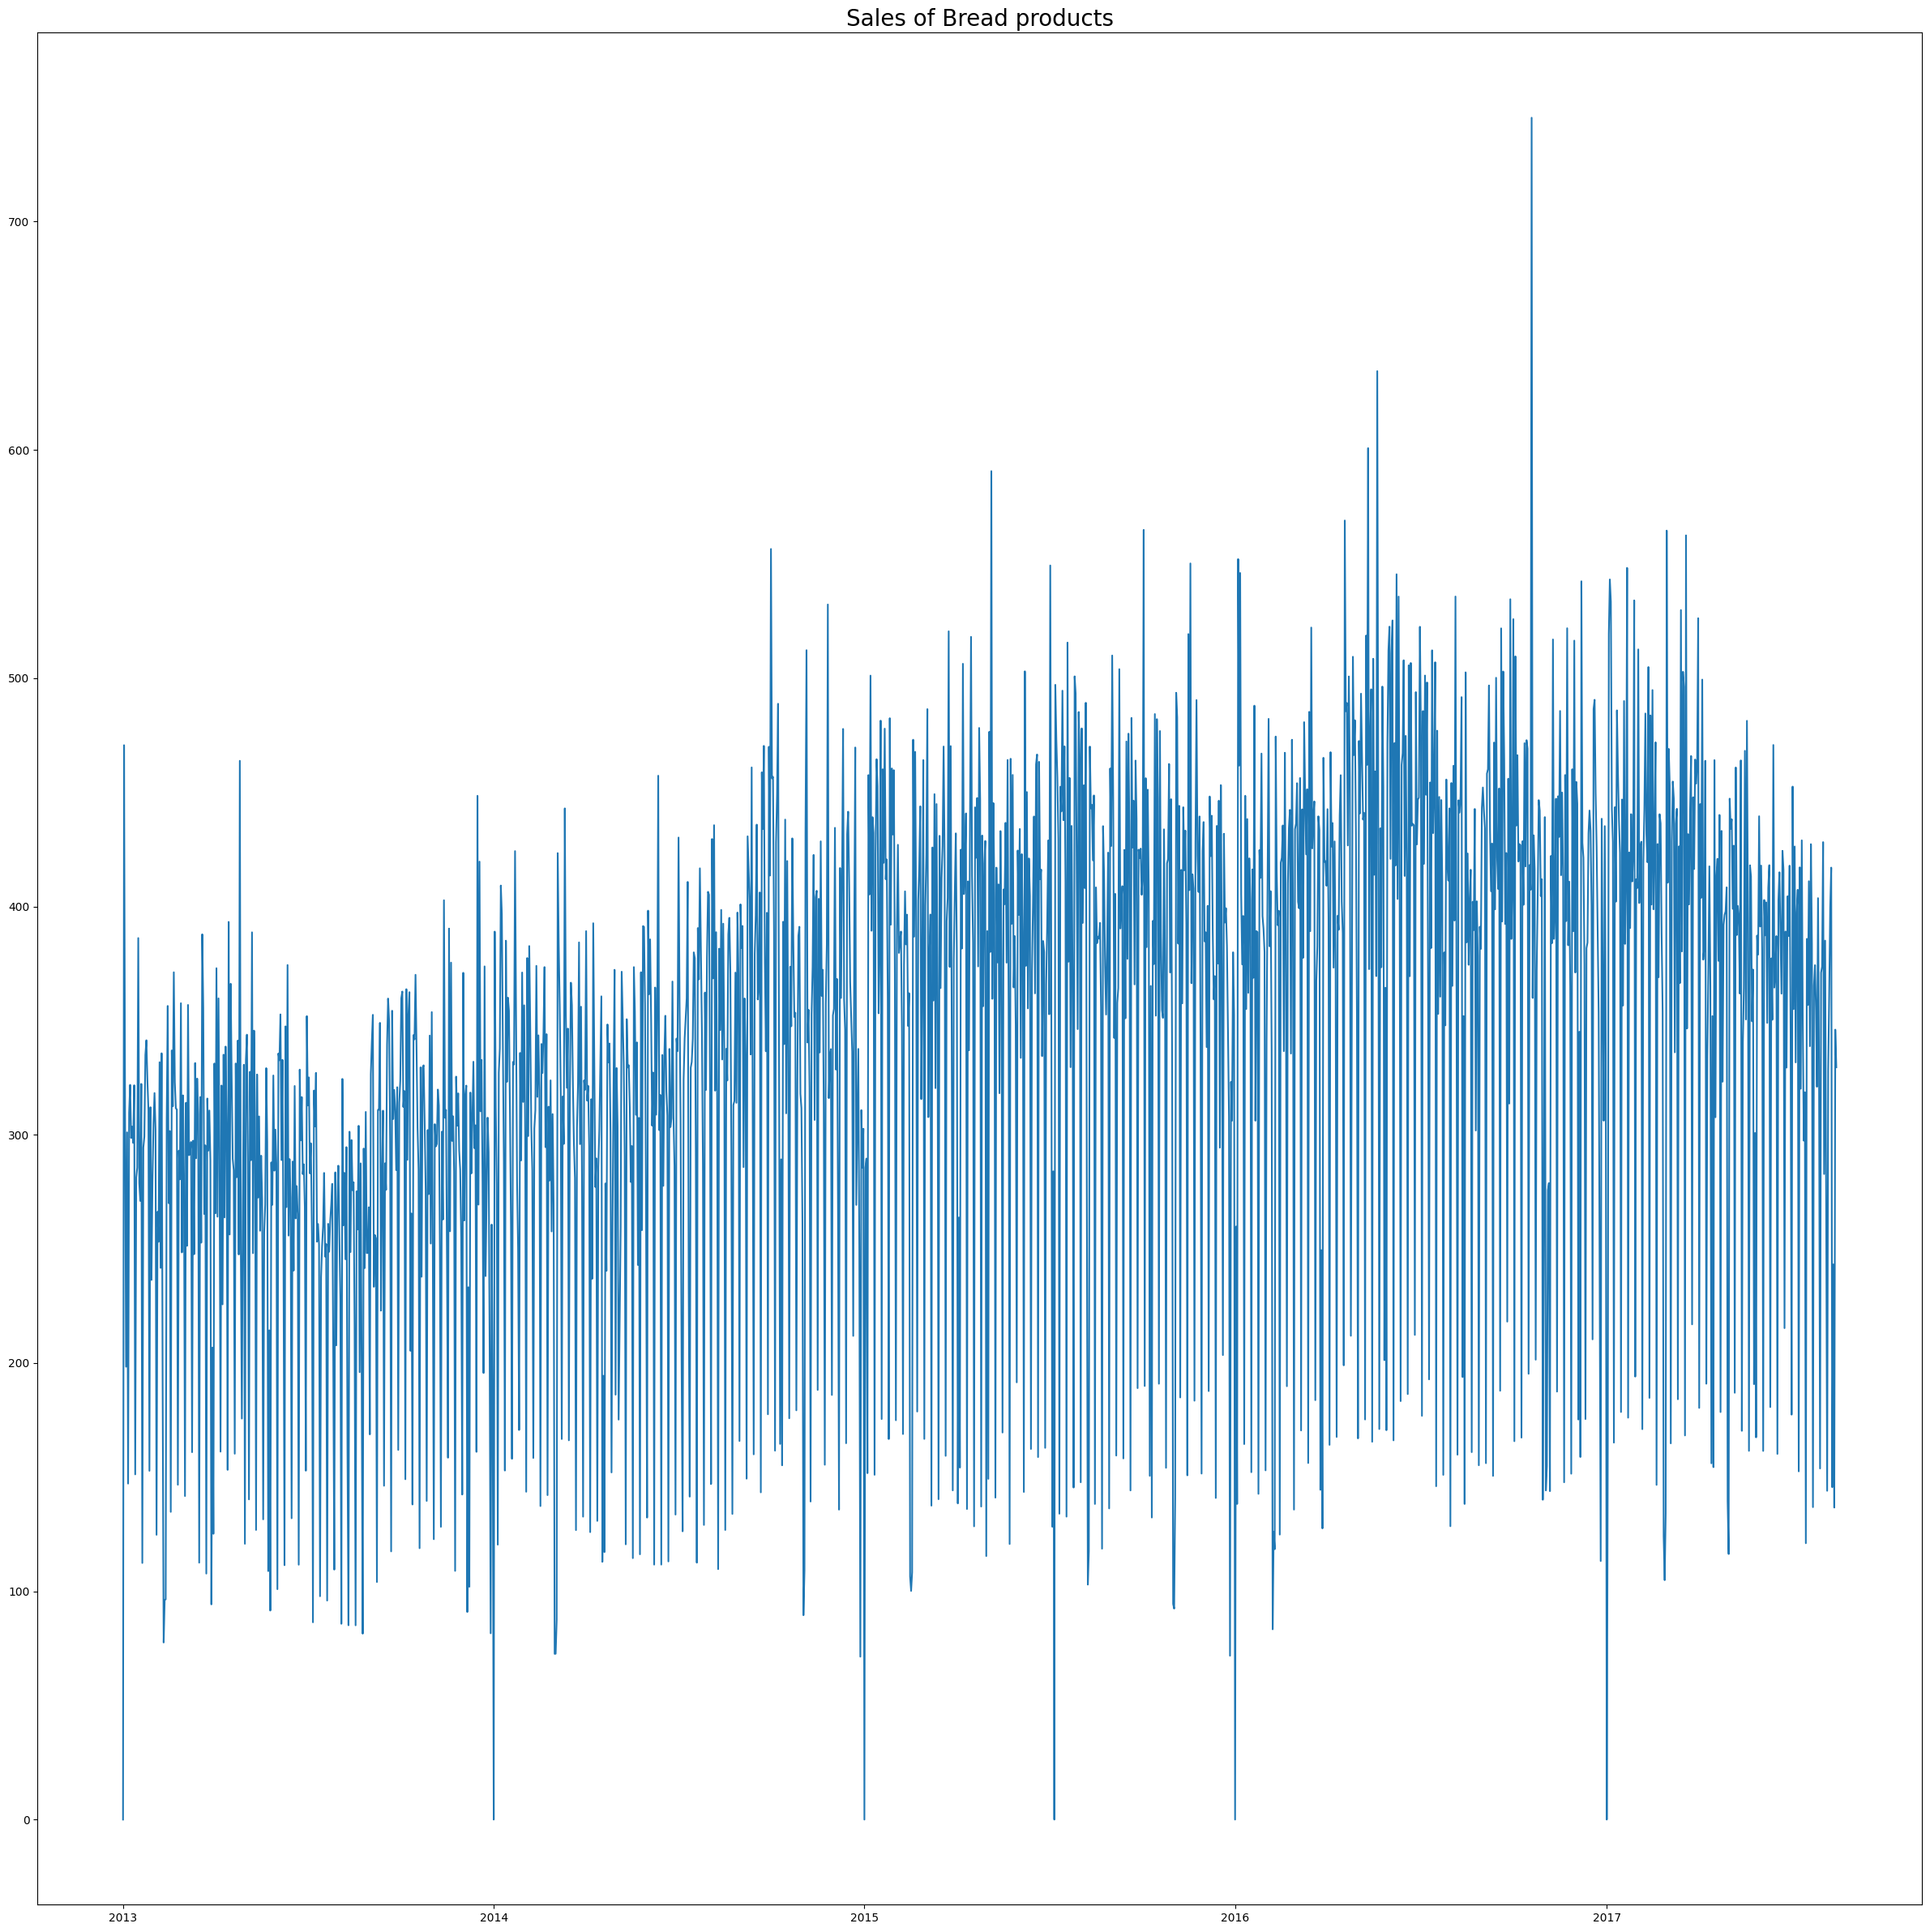

In [11]:
# Plot time series sales data
plt.figure(figsize=(30,30))
plt.title("Sales of Bread products", size=20)
plt.plot(df["sales"])

The plot illustrates the sales of bread/bakery products from January 2013 to September 2014, with time measured in days. Since the time series plot is difficult to interpret with so much data, we will be converting the time axis to weeks and aggregating the daily sales data into weekly means. This will provide a clearer picture of the sales trends over time and aid in data exploration and visualization. However, it's worth noting that the actual training data will still be in daily increments and only the visualization will be scaled down to weekly intervals.

                 sales  onpromotion  holiday
date                                        
2013-01-06  237.985333          0.0      2.0
2013-01-13  286.136854          0.0      1.0
2013-01-20  276.780999          0.0      0.0
2013-01-27  293.942143          0.0      0.0
2013-02-03  268.453429          0.0      0.0
...                ...          ...      ...
2017-07-23  348.582143          0.0      1.0
2017-07-30  328.990434          0.0      2.0
2017-08-06  322.335140         26.0      1.0
2017-08-13  290.266857         54.0      2.0
2017-08-20  337.789510         17.0      1.0

[242 rows x 3 columns]


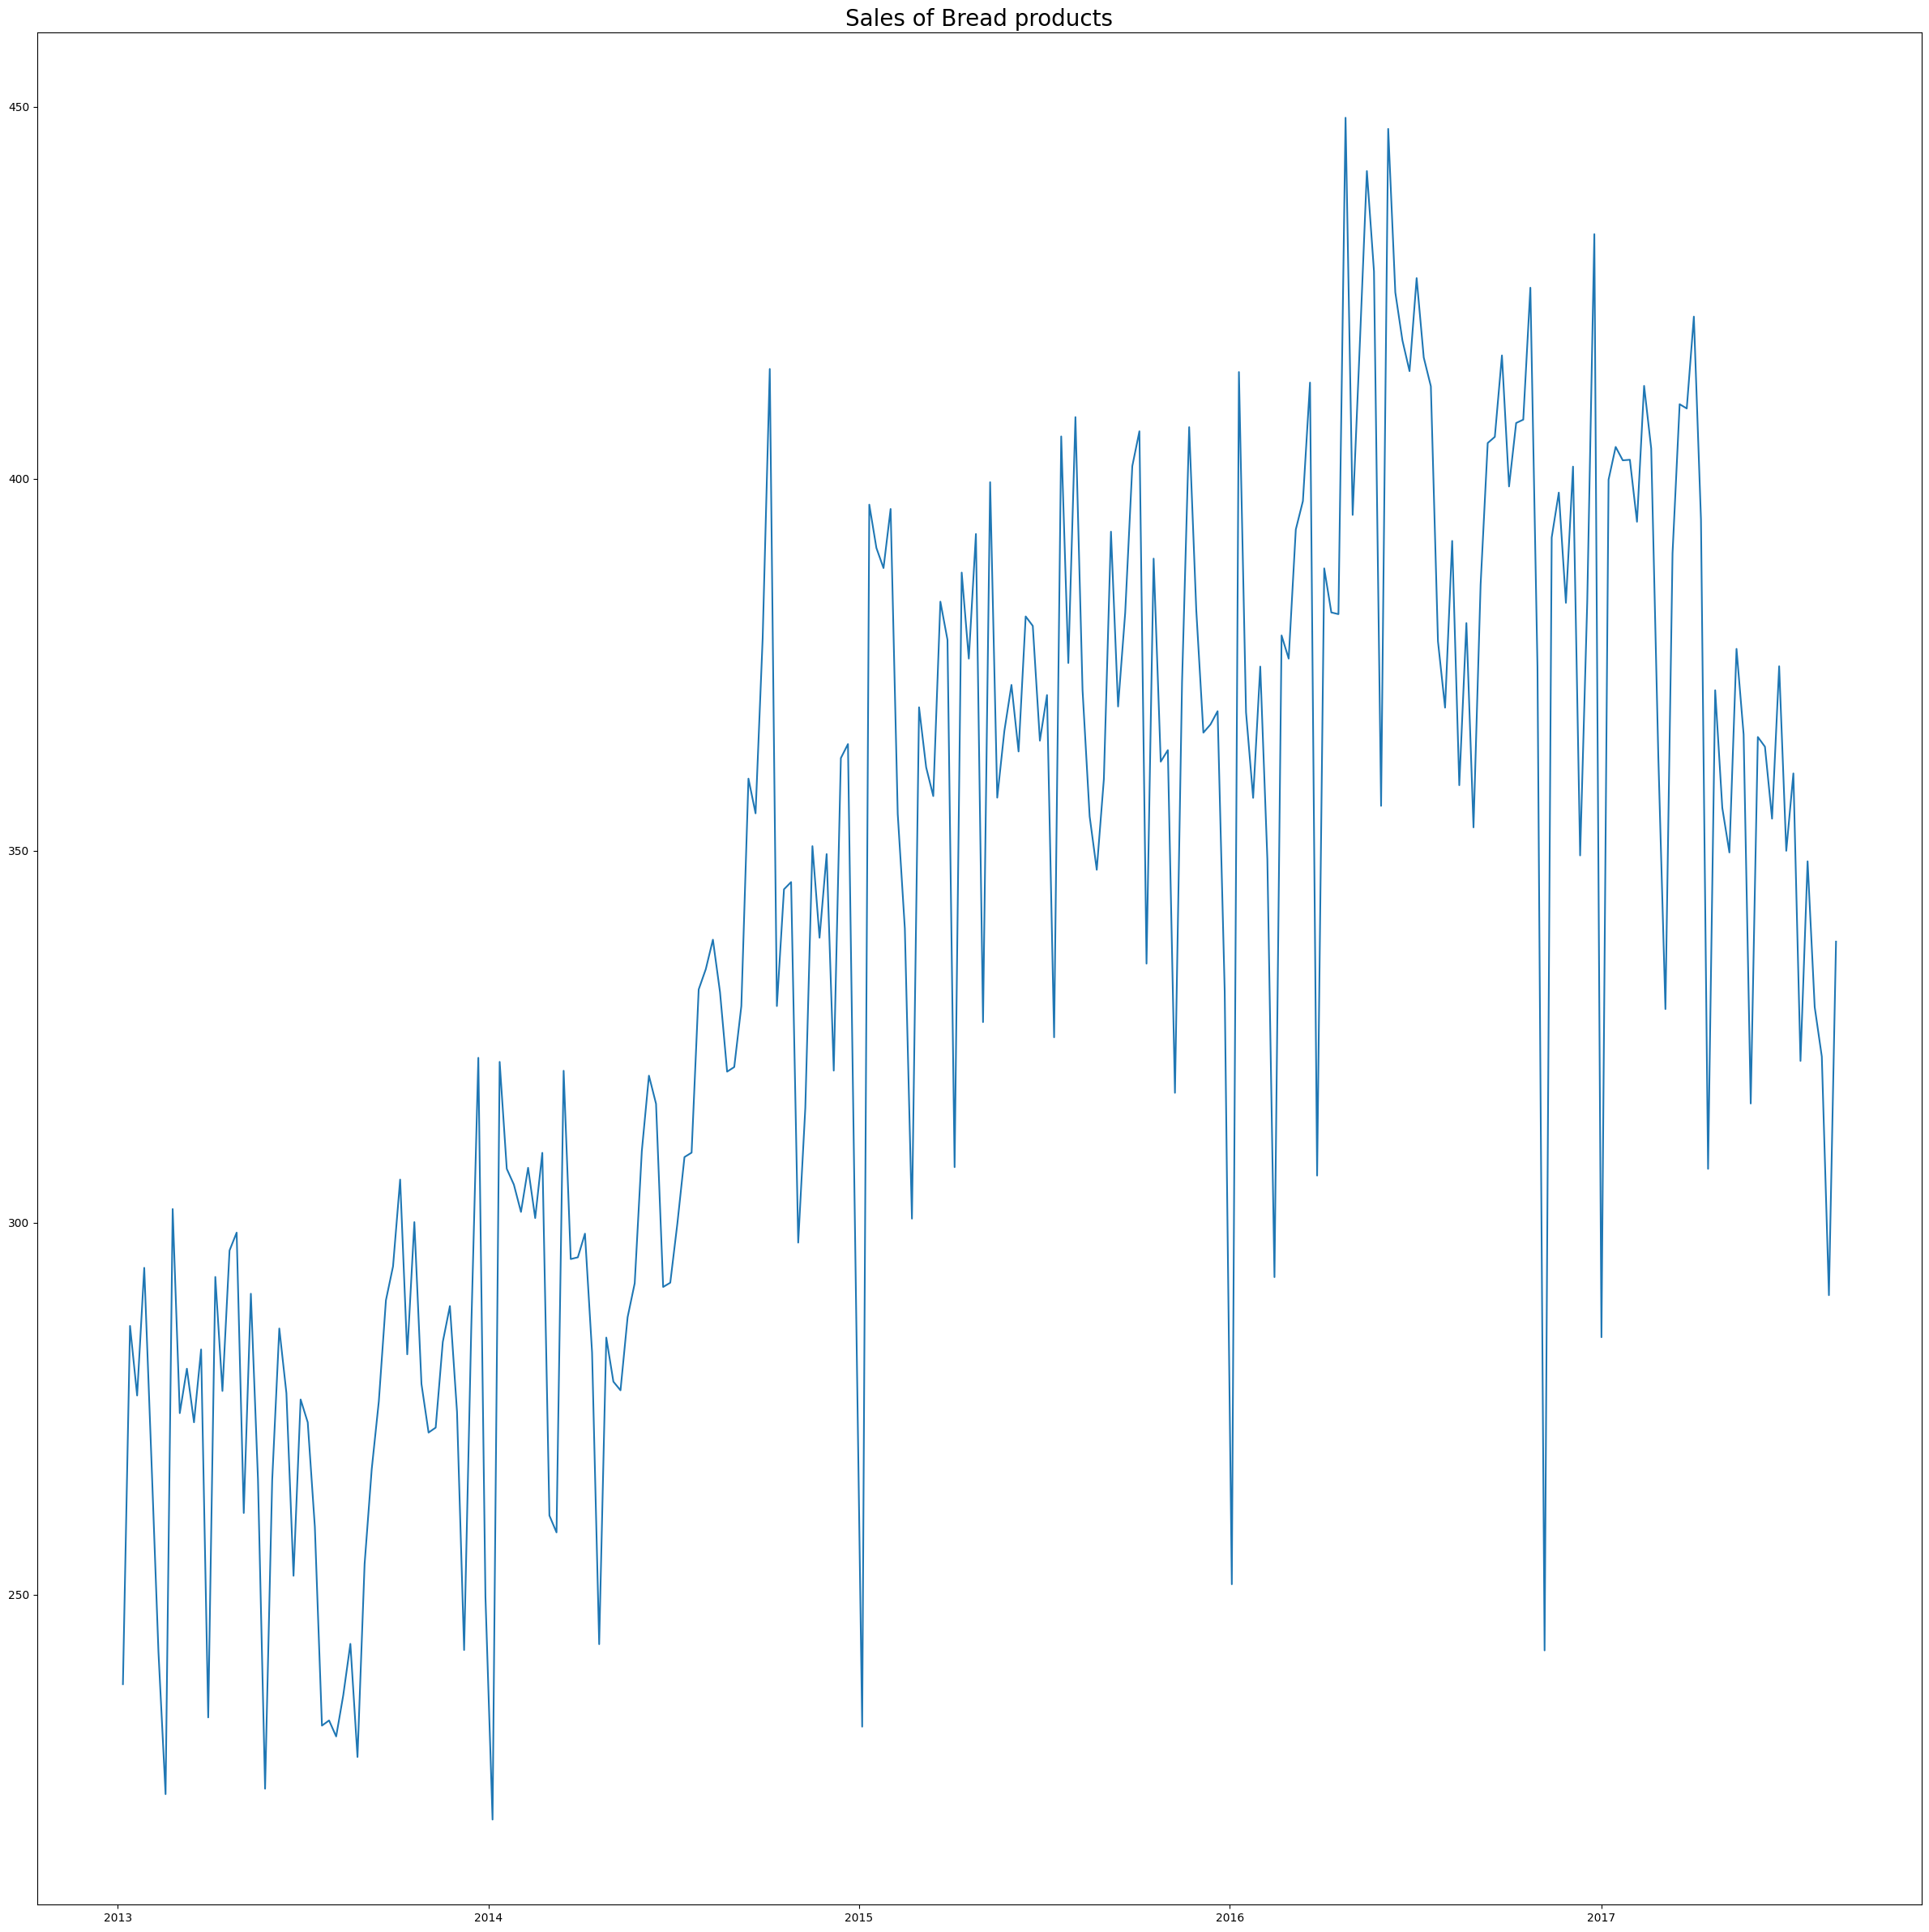

In [12]:
# Scale date range from days to week. Sales for the week is the mean
resampled_df = df.resample('W').agg({'sales':'mean','onpromotion':'sum','holiday':'sum'})
print(resampled_df)

# Plot time series sales data
plt.figure(figsize=(30,30))
plt.title("Sales of Bread products", size=20)
plt.plot(resampled_df['sales'])

The plot allows us to more easily visualize the trends in the estimated sales data over time. From our observation, it is apparent that the sales price of the time series is non-stationary, which means that the mean and variance of the sales data change as time progresses. This characteristic makes it challenging to forecast future trends using traditional time-series forecasting methods, as time itself becomes a variable that affects the predictions. We will delve further into this issue in subsequent analyses.

In [13]:
# Data summary
print("MEDIAN: ", df["sales"].median())
print("MEAN: ", df["sales"].mean())
print("SD: ", df["sales"].std())
print("MAX: ", df["sales"].max())
print("Min: ", df["sales"].min())


MEDIAN:  357.8425
MEAN:  338.4751828165083
SD:  111.28629048120915
MAX:  745.513
Min:  0.0


## Intro to ARIMA model
ARIMA is a popular time series model that combines three different models to analyze time series data: Auto Regressive (AR), Integrated (I), and Moving Average (MA). The name ARIMA reflects this combination of models.

1) Auto Regressive(AR)
It is a regression model that uses past values of the dependent variable (y) to predict future values.

2) Moving Average(MA)
This model analyzes the errors of the predicted values from the past and attempts to make more accurate predictions for the current time period.

3) Integrated (I)
Integrated (I) is not a separate model, but rather a method for dealing with non-stationary data. Stationary data satisfies three conditions: constant mean, constant standard deviation, and no seasonality. 

If the data is non-stationary, the I component is used to transform the data into a stationary state so that the AR and MA models can be applied.


The goal of this notebook is to identify the optimal hyperparameters for the AR, I, and MA components of the ARIMA model. By identifying the best parameters, we can train a model that provides accurate forecasts for our time series data.

# Stationarity of data (I-value)
As previously mentioned, stationarity is a crucial aspect of time series modeling, as it ensures that the model can accurately predict future values. When a time series exhibits a trend, it becomes more challenging to predict future values accurately. Conversely, when the time series is stationary, it is easier to forecast future values since the data does not vary widely.

From the plot above, we can observe that the sales data is not stationary. Specifically, we see that the sales of the store are increasing over time, which suggests the presence of a trend. However, we can confirm the stationarity of the data more accurately by using a statistical test such as the KPSS test.

In [14]:
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [15]:
# KPSS test
kpss_test(resampled_df["sales"])

Results of KPSS Test:
Test Statistic           1.992437
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\Creaton\PycharmProjects\SC1015proj\venv\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The results of the KPSS test can be interpreted as follows:
- If the test statistic is greater than the critical value, we reject the null hypothesis that the series is stationary. 
- If the test statistic is less than the critical value, we fail to reject the null hypothesis and conclude that the series is stationary.

In the case of our data, the test statistic was found to be 1.989824, which exceeded the critical value at all confidence intervals. This result indicates that we must reject the null hypothesis and conclude that the series is not stationary. 

To make the sales data stationary, we will employ a technique called "differencing.

# Differencing

Differencing is a technique used to remove trends from non-stationary time series data. The process involves calculating the differences between consecutive data points by subtracting the value of the previous observation from the value of the next observation.

In [16]:
# Split train test
size = round(len(resampled_df)*0.8)

train, test = resampled_df[0:size], resampled_df[size:len(resampled_df)]
print(train,'\n', test)
print(len(test))

                 sales  onpromotion  holiday
date                                        
2013-01-06  237.985333          0.0      2.0
2013-01-13  286.136854          0.0      1.0
2013-01-20  276.780999          0.0      0.0
2013-01-27  293.942143          0.0      0.0
2013-02-03  268.453429          0.0      0.0
...                ...          ...      ...
2016-08-21  380.598714         31.0      1.0
2016-08-28  353.142571         17.0      1.0
2016-09-04  385.760571         34.0      0.0
2016-09-11  404.805143         52.0      0.0
2016-09-18  405.633000         49.0      0.0

[194 rows x 3 columns] 
                  sales  onpromotion  holiday
date                                        
2016-09-25  416.577286         57.0      0.0
2016-10-02  398.965429         37.0      1.0
2016-10-09  407.494000          3.0      2.0
2016-10-16  407.945143          4.0      0.0
2016-10-23  425.679859          9.0      0.0
2016-10-30  374.680857         34.0      0.0
2016-11-06  242.522711       

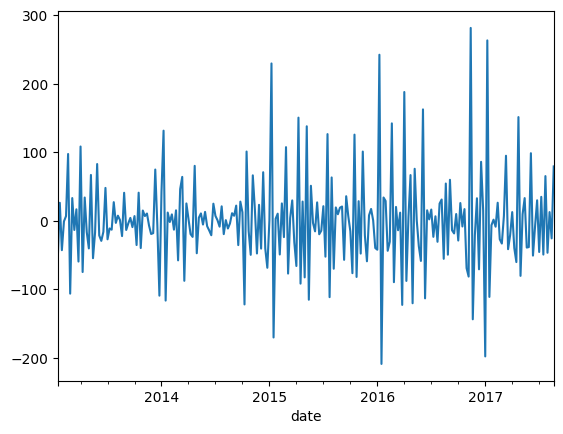

In [17]:
difference_df = resampled_df.copy(deep=True)

difference_df["sales"] = difference_df["sales"].diff()
difference_df["sales"] = difference_df["sales"].diff()
difference_df["sales"] = difference_df["sales"].diff()


difference_df["sales"].dropna().plot()
difference_df = difference_df[["sales", "onpromotion"]].dropna()

After performing differencing on the data, we can observe that the trend component of the time series has been removed.

In [18]:
kpss_test(difference_df["sales"])

Results of KPSS Test:
Test Statistic            0.088671
p-value                   0.100000
Lags Used                21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\Creaton\PycharmProjects\SC1015proj\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


After performing differencing on the data, we can re-run the KPSS test to verify that the time series data is now stationary. If the KPSS test statistic is lower than the critical values at all confidence intervals, then we can conclude that the data is now stationary.

The number of times we perform differencing is denoted as the 'I' value in the ARIMA model. In our case, we performed differencing thrice to achieve stationarity in the sales data. It's important to note that while stationarity can be achieved after a single round of differencing, our model showed improved performance with additional rounds of differencing.

# Finding MA value

Now that we have determined the appropriate value for 'I' in our ARIMA model, we will proceed to identify the optimal value for the Moving Average (MA) component. We can use Auto-Correlation Function (ACF) analysis to accomplish this. ACF measures the correlation between a time series and a lagged version of itself. Take for example the image below:


![ACF.png](attachment:846ffe02-1e87-4ee6-9712-4f4cf89be1c0.png)

In a time series, the price in a given month (M) can be directly affected by the price in the preceding month (F), which in turn can be directly affected by the price in the month before that (J). This implies that January's price can indirectly impact March's price. However, January's price can also directly impact March's price. The Auto-Correlation Function (ACF) analysis helps us determine the best lagged period to use in our ARIMA model by measuring the correlation between each observation in the time series and its past lags. For instance, we can use the ACF plot to identify whether the price of January (t-2) or the price of February (t-1) better predicts the price of March (t).

(Image taken from: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)

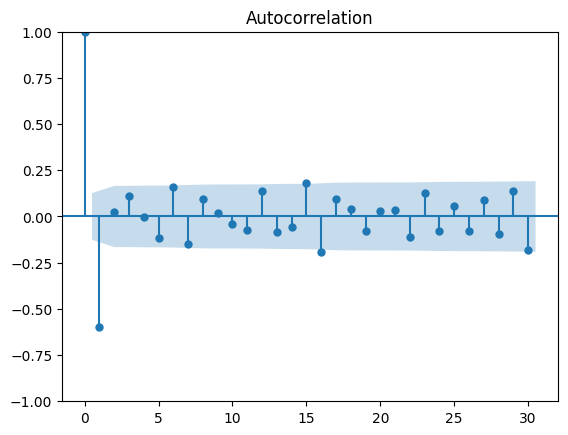

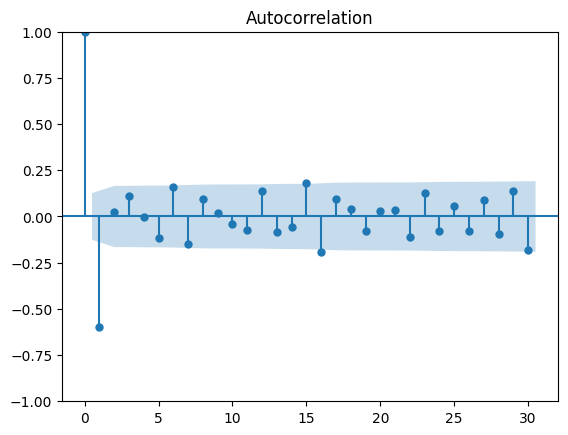

In [19]:
# ACF test
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(difference_df["sales"], lags = 30)

NOTE: When using ACF to identify the optimal value for the MA component, it's important to exclude lag 0 from the analysis since it represents the correlation between the time series and itself. This correlation is always equal to 1 and is therefore not useful in our analysis.

From the ACF plot, we can observe that the highest correlation occurs at lag 1, indicating that the optimal value for the MA component in our ARIMA model is 1. We can ignore any correlation values that fall within the blue box, as these values are not statistically significant.

# Finding AR value
To identify the optimal value for the Auto Regressive (AR) component in our ARIMA model, we can use Partial Auto-Correlation Function (PACF) analysis. PACF measures the correlation between a time series and its own lags, while removing the indirect effects of other lags. (In the example above, how price of Jan affect price of March.)

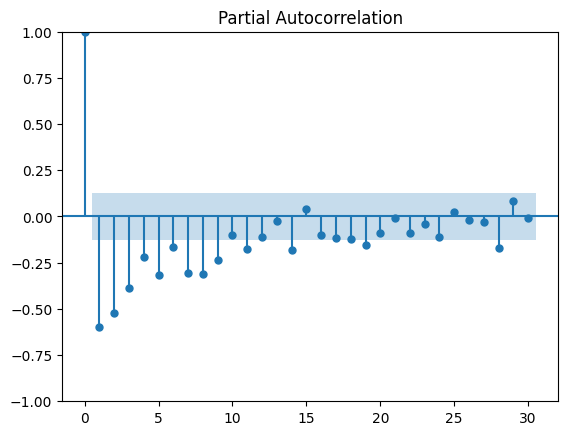

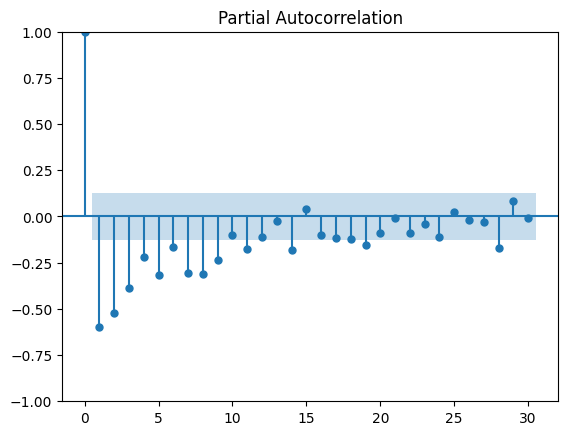

In [20]:
# PACF test
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(difference_df["sales"], lags = 30, method = "ols")

As with ACF analysis, when using PACF to identify the optimal value for the AR component, we should exclude lag 0 from the analysis. From our PACF, we observe the highest correlation at lag 1, indicating that the optimal value for the AR component in our ARIMA model is 1. So that is our value for AR.

# Prediction

After determining the optimal values for the AR, I, and MA components of our ARIMA model, we can train the model using the time series data. We can then use the trained model to make predictions about future sales trends.

(Note that the ARIMA function given by statsmodel already does the differencing for us in the function, so we only need to feed in the raw data, not the differenced data.)

In [21]:
# predict

history = [x for x in train["sales"]]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(1,3,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test["sales"][t]

    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

C:\Users\Creaton\PycharmProjects\SC1015proj\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted = 417.263899, expected = 416.577286
predicted = 421.269122, expected = 398.965429
predicted = 398.269150, expected = 407.494000
predicted = 400.040222, expected = 407.945143
predicted = 413.069749, expected = 425.679859
predicted = 432.875253, expected = 374.680857
predicted = 364.753117, expected = 242.522711
predicted = 157.445863, expected = 392.100429
predicted = 368.168609, expected = 398.140286
predicted = 491.530584, expected = 383.326571
predicted = 380.521521, expected = 401.633857
predicted = 400.246547, expected = 349.374000
predicted = 338.439226, expected = 383.425571
predicted = 365.920635, expected = 432.872500
predicted = 473.386541, expected = 284.616143
predicted = 252.525723, expected = 399.878714
predicted = 351.091748, expected = 404.280141
predicted = 476.279647, expected = 402.477143
predicted = 404.200972, expected = 402.554571
predicted = 401.293348, expected = 394.220000
predicted = 390.692978, expected = 412.487286
predicted = 414.635954, expected =

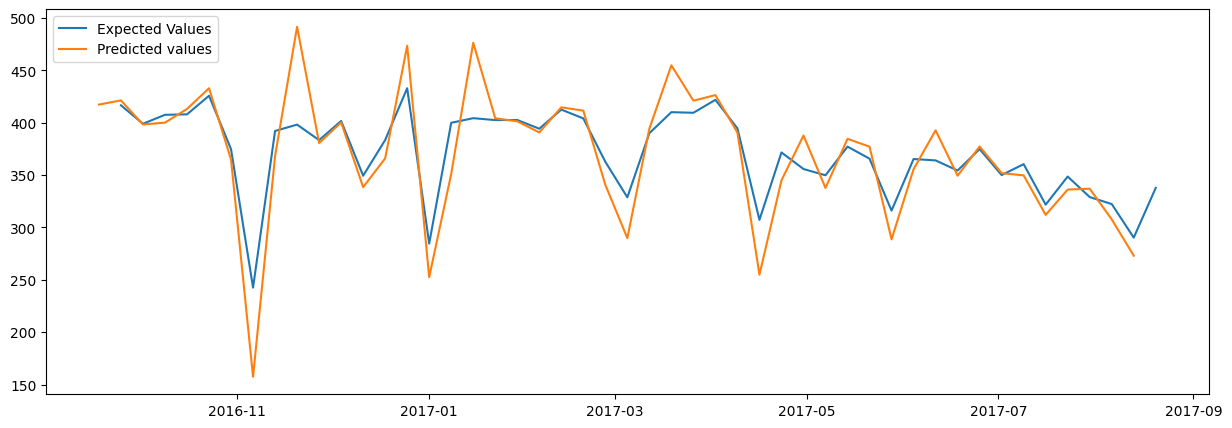

In [22]:
predictions_series = pd.Series(predictions, index = test.index.shift(-1))
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(test["sales"],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted values');
plt.legend(loc="upper left")
plt.show()

This is the results of the model.

# Evaluate using RMSE

In [23]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(predictions_series, test['sales'], squared=False)
print("RMSE: ", rmse)

RMSE:  68.00886845206703


# Adding of exog variables

So far, we have used past values of the sales data to make predictions about future trends. However, we can also consider other variables that may have an impact on sales, such as the number of items on promotion and the occurrence of holidays. By incorporating these variables into our ARIMA model, we can create a more comprehensive and accurate forecasting tool. This involves adding these variables as exogenous inputs to the ARIMA model.

In [24]:
# predict

exog_history = [x for x in train["sales"]]
exog_history_exog = [x for x in train[["onpromotion", "holiday"]].to_numpy()]
exog_predictions = []
exog_future_exog = [x for x in test[['onpromotion', "holiday"]].to_numpy()]

for t in range(len(test)):
    
    exog_model = ARIMA(exog_history, order=(1,3,1), exog=exog_history_exog)
    exog_model_fit = exog_model.fit()
    
    exog_output = exog_model_fit.forecast(exog=exog_future_exog[t])
    exog_yhat = exog_output[0]
    exog_predictions.append(float(exog_yhat))
    obs = test["sales"][t]

    exog_history.append(obs)
    exog_history_exog.append(exog_future_exog[t])
    
    print('predicted = %f, expected = %f' % (exog_yhat, obs))

C:\Users\Creaton\PycharmProjects\SC1015proj\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted = 417.664179, expected = 416.577286
predicted = 410.897282, expected = 398.965429
predicted = 391.804131, expected = 407.494000
predicted = 428.923374, expected = 407.945143
predicted = 412.472426, expected = 425.679859
predicted = 421.225478, expected = 374.680857
predicted = 328.541032, expected = 242.522711
predicted = 174.862934, expected = 392.100429
predicted = 431.029984, expected = 398.140286
predicted = 472.098261, expected = 383.326571
predicted = 359.748900, expected = 401.633857
predicted = 384.863916, expected = 349.374000
predicted = 378.733643, expected = 383.425571
predicted = 324.118356, expected = 432.872500
predicted = 480.347296, expected = 284.616143
predicted = 302.787227, expected = 399.878714
predicted = 337.165462, expected = 404.280141
predicted = 461.713326, expected = 402.477143
predicted = 397.918450, expected = 402.554571
predicted = 400.255101, expected = 394.220000


C:\Users\Creaton\PycharmProjects\SC1015proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 391.793936, expected = 412.487286
predicted = 411.437392, expected = 404.060714
predicted = 410.748484, expected = 362.649006
predicted = 321.853397, expected = 328.723143
predicted = 325.173324, expected = 389.972714
predicted = 392.813828, expected = 410.020714
predicted = 437.776236, expected = 409.445857
predicted = 412.942851, expected = 421.795571
predicted = 441.488342, expected = 394.529000
predicted = 365.307852, expected = 307.247569
predicted = 284.122610, expected = 371.575571
predicted = 361.986204, expected = 355.761714
predicted = 361.590242, expected = 349.771714
predicted = 311.311623, expected = 377.135571
predicted = 430.217430, expected = 365.636000
predicted = 360.456885, expected = 316.029571
predicted = 298.506646, expected = 365.291429
predicted = 357.286889, expected = 363.984714
predicted = 381.591616, expected = 354.314143
predicted = 329.163742, expected = 374.797286
predicted = 405.141001, expected = 349.996143
predicted = 348.085080, expected =

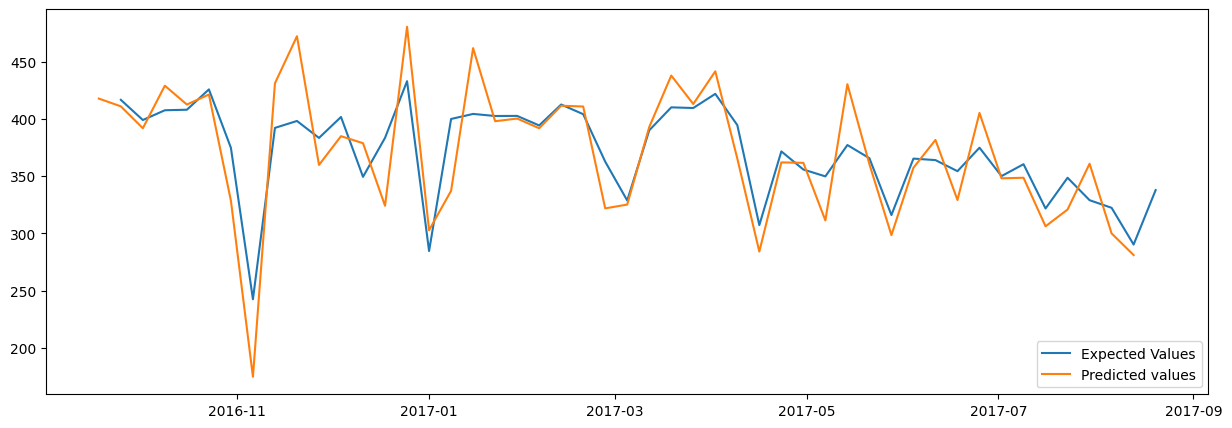

In [25]:
exog_predictions_series = pd.Series(exog_predictions, index = test.index.shift(-1))
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(test["sales"],label = 'Expected Values')
plt.plot(exog_predictions_series,label = 'Predicted values');
plt.legend(loc="lower right")
plt.show()

In [26]:
exog_rmse = mean_squared_error(exog_predictions_series, test['sales'], squared=False)
print("Exog_RMSE: ", exog_rmse)

Exog_RMSE:  62.4820582868575


# Comparison between with Exog variables and without

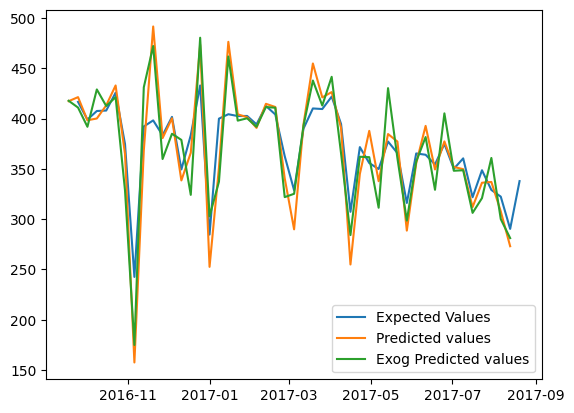

In [30]:
plt.subplot(1,1,1)
plt.plot(test["sales"],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted values');
plt.plot(exog_predictions_series,label = 'Exog Predicted values');
plt.legend(loc="lower right")
plt.show()

In [31]:
rmse = mean_squared_error(predictions_series, test['sales'], squared=False)
exog_rmse = mean_squared_error(exog_predictions_series, test['sales'], squared=False)
print("RMSE: ", rmse)
print("Exog_RMSE: ",exog_rmse)

RMSE:  68.00886845206703
Exog_RMSE:  62.4820582868575


After incorporating the exogenous variables into our ARIMA model, we observed a slight improvement in the model's performance.

# Conclusion

In this notebook, we managed to train a time series model (ARIMA) to predict food sales for specific categories on a weekly basis has the potential to help businesses better plan their inventory and reduce food waste by avoiding over-ordering. This can contribute to achieving Goal 12 of responsible consumption and production.

Through exploratory data analysis (EDA), we were able to identify key trends and variables that impact food sales, such as the number of items on promotion and the occurrence of holidays. By incorporating these variables as exogenous inputs into our ARIMA model, we were able to improve its accuracy and reliability.

Overall, our approach demonstrates the potential benefits of using data-driven insights and machine learning techniques to optimize business operations and improve sales forecasting. By doing so, businesses can make more informed decisions and ultimately contribute to sustainable and responsible consumption and production practices.

---